# Step 3: Stress-Testing
#### MORDM - Evaluating Multi-Disease Interventions - MSc Engineering and Policy Analysis

Shannon M. Gross

In [37]:
# standard packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import time, copy
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', 100)

# EMA imports
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress) 
from ema_workbench import (SequentialEvaluator, MultiprocessingEvaluator, Policy, Scenario, Constraint, CategoricalParameter,
                           TimeSeriesOutcome, ScalarOutcome, IntegerParameter, RealParameter, save_results, load_results, Model)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.parameters import create_parameters
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import (pairs_plotting, plotting, plotting_util, feature_scoring, parcoords)
from ema_workbench.analysis.plotting import lines, Density
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

# problem-specific imports
from disease_model_problems import get_model_for_problem_formulation 

#### 3.1 Generate uncertainity ensemble
- The first step to stress-testing across many different future states of the world is to generate an uncertainty ensemble. Each ensemble is a set of vectors containing values for the uncertain parameters. 
- Running this ensemble against the promising policy results allows the implications of a wide range of combinations of these uncertain values to be explored. It is useful to create this scenario ensemble upfront, so that each problem formulation can be tested against the same set of uncertainty combinations.

In [39]:
disease_model = get_model_for_problem_formulation(1) 

n_scenarios=300
scenarios = sample_uncertainties(disease_model, n_scenarios)

#### 3.2 Perform experiments
- Once the ensemble of 300 scenarios is generated, the promising candidates are subjected to experimentation in order to see which ones are still high-performing

In [ ]:
nfe = 75000

for PF in range(4,5):
    print("Retrieving solutions found from directed search under PF {}".format(PF))
    file_name = './results/promising_candidates/PF{}_nfe{}'.format(PF,nfe) + '.csv'
    
    mylist = []
    for chunk in  pd.read_csv(file_name, 
                              chunksize=100,
                              header=0,
                              sep=',', ):
        mylist.append(chunk)
    df_pareto = pd.concat(mylist, axis= 0)
    del mylist
    
    print("{} solutions were found in step 2".format(len(df_pareto)))
    disease_model = get_model_for_problem_formulation(PF)
    
    # Hard constraint. Only lowest quartile of Recurring Cost
    fatality_constraint = df_pareto['Mortality'] < df_pareto['Mortality'].quantile(.25)
    constrained_results = df_pareto[fatality_constraint]
    print('Satisfactory policies found', np.sum(len(constrained_results)))

    # Select the policies 
    policies = constrained_results.drop([o.name for o in disease_model.outcomes], axis=1).reset_index(drop=True) 
    policies_to_evaluate = []
    for i, policy in policies.iterrows():
        policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
    n_policies = len(policies)

    start = time.time()
    with MultiprocessingEvaluator(disease_model, n_processes=8) as evaluator:
        reeval_results = evaluator.perform_experiments(
                                            scenarios = scenarios,
                                            policies= policies_to_evaluate,
        )
        file_name = r'.\results\robust_candidates\PF{}_nfes{}'.format(PF, nfe) + '.tar.gz'
        
        save_results(reeval_results, file_name)
    end = time.time()
    print('Experimentation time for PF {} is '.format(PF) + str(round((end - start)/60)) + ' mintues')
    print("")

Retrieving solutions found from directed search under PF 4
6602 solutions were found in step 2
Satisfactory policies found 661


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 250 scenarios * 661 policies * 1 model(s) = 165250 experiments
[MainProcess/INFO] 16525 cases completed
[MainProcess/INFO] 33050 cases completed
[MainProcess/INFO] 49575 cases completed
[MainProcess/INFO] 66100 cases completed
[MainProcess/INFO] 82625 cases completed
[MainProcess/INFO] 99150 cases completed


#### 3.3 Calculate 90th percentile minimax regret

In [40]:
## NEW ROBUSTNESS CALC TEST
nfe=15000
for PF in [3]:
    print('Retrieving Problem Formulation {} '.format(PF) )
    disease_model = get_model_for_problem_formulation(PF)   
    file_name = r'.\results\robust_candidates\robust_PF{}_nfes{}'.format(PF, nfe) + '.tar.gz'
    pareto_results = load_results(file_name)
    experiments, outcomes = pareto_results

    ## 90th percentile regret calculation
    overall_regret = {}
    quant_regret ={}
    for outcome in disease_model.outcomes:
        policy_column = experiments['policy']
        # PUT INTO LONG FORM (policy name, scenario_id, and outcome scores)
        data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
        data = data.pivot(index='scenario', columns='policy')
        data.columns = data.columns.get_level_values(1)
        outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
        #90th percentile 
        quant_regret[outcome.name] = outcome_regret.quantile(.9)
        quant_regret = pd.DataFrame(quant_regret)
    #Normalize regret
    percentile_regret_norm = (quant_regret-quant_regret.min())/(quant_regret.max()-quant_regret.min())
    percentile_regret_norm.fillna(0, inplace=True)


    ## COMBINE REGRET AND LEVERS FOR VISUALIZATION
    levers = [l.name for l in disease_model.levers] 
    df_out = pd.DataFrame(outcomes)
    df_out = df_out.assign(policy=experiments['policy'])
    actual_outcomes = df_out.groupby('policy').mean() # do you want to merge w actual outcomes or regret metrics
    #df_max_regret_norm
    df_out_pols = df_out.drop_duplicates(['policy'])
    pollist = list(df_out_pols['policy']) #gives mean of experiment

    subset_cols=['policy']
    subset_cols.extend(levers)
    df_options = experiments[subset_cols]
    policy_levers = df_options[df_options['policy'].isin(pollist)].drop_duplicates(keep='last')

    levers_and_regret = policy_levers.merge(percentile_regret_norm, on='policy')
    
    levers_and_regret.drop(columns=['policy'], inplace=True)
    levers_and_regret.rename(columns={'Availability HWT':'% HWT availability',
                        'Access to tmt':'% ORT availability',
                        'percent adults given MDA':'% Adults MDA',
                        'percent youth given Albendazole':'% Youth MDA',
                        'percentage of infants to vaccinate':'% Infants vaccinated',
                        'HW stations to build':'HW stations to build',
                        'Number of new latrines to build':'Latrine construction',
                        'Number of latrines to maintain':'Latrine maintenance',
                        'Number of new wells to drill':'Well construction',
                        'Number of wells to repair':'Well repair',
                      }, 
                 inplace=True)
    
    file_n = './results/robust_candidates/regret/PF{}levers_and_regret'.format(PF) + '.csv'
    levers_and_regret.to_csv(file_n)

Retrieving Problem Formulation 3 


[MainProcess/INFO] results loaded succesfully from C:\Users\sgross\Documents\FRIDAY\disease_model\results\robust_candidates\robust_PF3_nfes15000.tar.gz


#### 3.4 Nice plots

In [41]:
#PARAPLOTS
lim_df = pd.DataFrame()

for PF in [3]:
    file_n = './results/robust_candidates/regret/PF{}levers_and_regret'.format(PF) + '.csv'
    levers_and_regret = pd.read_csv(file_n)
    levers_and_regret.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)
    levers_and_regret['regret_sum'] = levers_and_regret[['Mortality','Morbidity','Timeliness','CapEx','OpEx']].sum(axis=1)
    lim_df = lim_df.append(levers_and_regret, ignore_index=True)

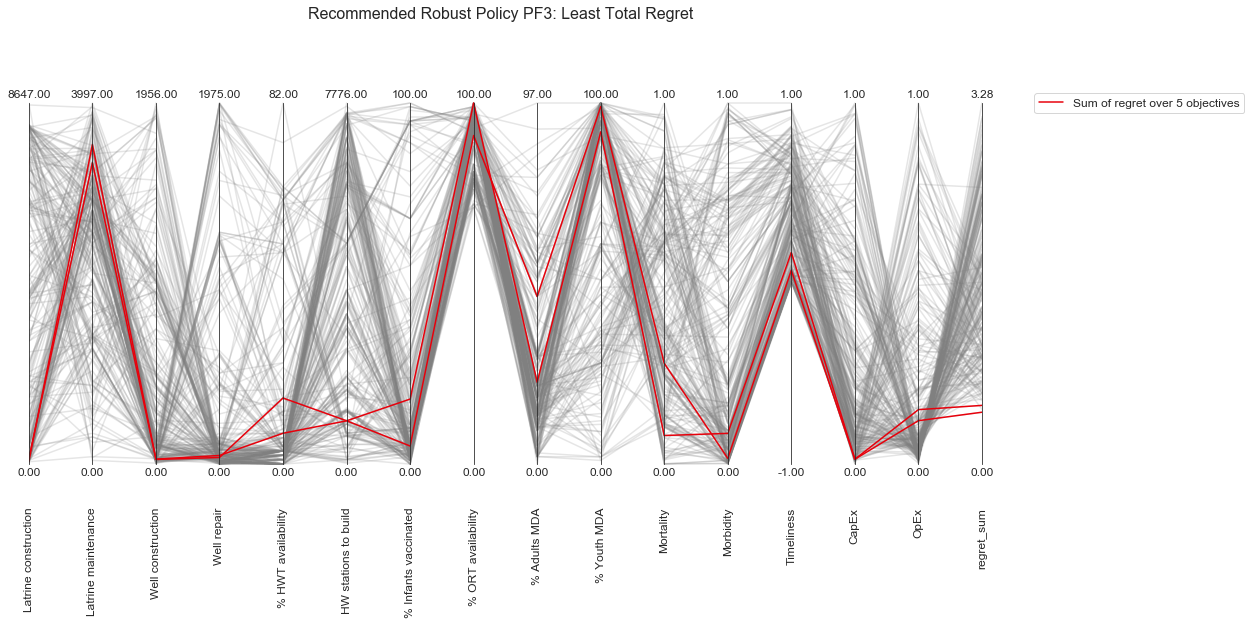

In [51]:
for PF in [3]:
    file_n = './results/robust_candidates/regret/PF{}levers_and_regret'.format(PF) + '.csv'
    levers_and_regret = pd.read_csv(file_n)
    levers_and_regret.drop(columns=['Unnamed: 0'], errors='ignore',inplace=True)
    levers_and_regret['regret_sum'] = levers_and_regret[['Mortality','Morbidity','Timeliness','CapEx','OpEx']].sum(axis=1)
    
    limits = parcoords.get_limits(lim_df)
    limits.loc[0,:]=0
    limits.loc[0, 'Timeliness']=-1
    

    low_sum = levers_and_regret[levers_and_regret['regret_sum']<np.percentile(levers_and_regret['regret_sum'],1)]
    #low_mort = levers_and_regret[levers_and_regret['Mortality']==0]    
    
    paraxes = parcoords.ParallelAxes(limits,fontsize=12,rot=90)
    for i, (index, row) in enumerate(levers_and_regret.iterrows()):
        paraxes.plot(row.to_frame().T, color = 'grey', alpha=.2)
    
    palette = sns.color_palette("bright")
#     paraxes.plot(low_opex, label='Least OpEx Regret', color=palette[1])   
#     paraxes.plot(low_capex, label='Least CapEx Regret', color=palette[2])  
    paraxes.plot(low_sum, label='Sum of regret over 5 objectives', color=palette[3])  
    
    fig = plt.gcf()
    fig.set_size_inches(14,8)
    plt.suptitle('Recommended Robust Policy PF{}: Least Total Regret'.format(PF), fontsize=16, y=1.08)
    paraxes.legend()
    plt.show()

In [50]:
low_sum

,Latrine construction,Latrine maintenance,Well construction,Well repair,% HWT availability,HW stations to build,% Infants vaccinated,% ORT availability,% Adults MDA,% Youth MDA,Mortality,Morbidity,Timeliness,CapEx,OpEx,regret_sum
34,4091.0,3067.0,293.0,72.0,35.0,4711.0,92.0,99.0,18.0,100.0,0.001230,0.001663,0.008230,0.206134,0.370736,0.587994
45,6152.0,2674.0,89.0,435.0,11.0,6136.0,68.0,100.0,79.0,91.0,0.016176,0.087697,0.062384,0.150590,0.260136,0.576983
107,139.0,3336.0,25.0,36.0,15.0,933.0,5.0,91.0,45.0,99.0,0.279097,0.015894,0.073336,0.013488,0.150698,0.532513
242,73.0,3537.0,27.0,47.0,7.0,931.0,18.0,100.0,22.0,92.0,0.079040,0.085082,0.172857,0.013372,0.120122,0.470474


#### Additional: Interactive graph for testing

In [22]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line =  dict(color = levers_and_regret['Mortality'],
                     colorscale = 'spectral',
                     showscale = True,),
#                     reversescale=True,
#                      cmin = 0,
#                      cmax = 100),
        dimensions = list([
            dict(range = [0,8000],
                 label = "Build Latrines", values = levers_and_regret['Number of new latrines to build']),
            dict(range = [0,4000],
                 label = 'Fix Latrines', values = levers_and_regret['Number of latrines to maintain']),
            dict(range = [0,100],
                 label = 'ORT', values = levers_and_regret['% ORT availability']),
            dict(range = [0,100],
                 label = 'MDA', 
                 values = levers_and_regret['% Youth given MDA']),           
            dict(range = [0,8000],
                 label = 'Hygiene', 
                 values = levers_and_regret['Handwashing stations to build']),
            dict(range = [0,100],
                 label = 'Vaccination', 
                 values = levers_and_regret['% Infants vaccinated']),
            dict(range = [0,1],
#                  constraintrange = [0,0.3],
                 label = 'Mortality', values = levers_and_regret['Mortality']),
            dict(range = [0,1],
#                  constraintrange = [0,0.3],
                 label = 'Morbidity', values = levers_and_regret['Morbidity']),
            dict(range = [0,1],
                 label = 'Prevalence', values = levers_and_regret['Timeliness']),
            dict(range = [0,1],
                 label = 'Capex', values = levers_and_regret['CapEx']),
            dict(range = [0,1],
#                 constraintrange = [0,0.3],
                 label = 'Opex', values = levers_and_regret['OpEx']),
        ]), tickfont = dict(size=8)
    ))
#
fig.show()

#### 3.4 Save robust policies

In [2]:
# [o.name for o in disease_model.outcomes][0]

In [1]:
# for PF in range(1,2):
#     print('regret from Problem Formulation {} '.format(PF) )
#     file_name = r'.\results\RobustCandidates\PF{}'.format(PF) + '.tar.gz'
#     pareto_results = load_results(file_name)
#     experiments, outcomes = pareto_results
    
#     disease_model = get_model_for_problem_formulation(PF)

#     cleaned_experiments = experiments.drop(labels=[l.name for l in disease_model.levers], axis=1)
#     #cleaned_experiments2 = cleaned_experiments.drop([ 'policy'], axis=1)
#     cleaned_experiments3 = cleaned_experiments.drop([ 'Unnamed: 0'], axis=1)
#     outs = [o.name for o in disease_model.outcomes] #
   
#     for i in range(1,2):
#         data = outcomes[outs[i]]
#         y = data < np.percentile(data, 10) #focus on the worst 10 percent for Mortality
    
#         prim_alg = prim.Prim(cleaned_experiments3, y, threshold=0.8)
#         box1 = prim_alg.find_box()  
#         box1.show_tradeoff()
#         plt.title("Peeling Trajectory for *{}* under PF {}".format(outs[i], PF))
#         plt.figure(figsize=(4,4)) 
#         plt.show()